### data import
- Data is downloaded and converted to pickle file
- [Download location](http://yann.lecun.com/exdb/mnist/)
- Extraction using mlxtend library. sample code [reference](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)

### code for importing and converting the data into pickle files

The original dataset as imported from website which contributes the dataset for public usage is in unsigned byte format. The dataset is in flattened format and has single channel 28\*28 images flattened row-wise. The images are rebuilt using one of the many codes contributed by various users working on the same dataset.

For ease of use, here we have converted the dataset to standard pickle format as the library is generally more readily available on most platforms when compared to the mlxtend library originally mentioned. 

```python
from mlxtend.data import loa local_mnist
import pickle as pkl

X, y = loadlocal_mnist(
        images_path='data/MNIST/train-images-idx3-ubyte', 
        labels_path='data/MNIST/train-labels-idx1-ubyte')

pkl.dump((X, y), open('data/MNIST/data.pkl', 'wb'))
```

In [1]:
import pickle as pkl

In [2]:
X, y = pkl.load(open('data/MNIST/data.pkl', 'rb'))
X.shape, y.shape

((60000, 784), (60000,))

### Data Processing
- convert data to the appropriate format and check the label against sample instances for validation.
- data is presented in a single row vector as flattened values for 28\*28 images

In [3]:
import matplotlib.pyplot as plt
import random

### Validation Plot

Plotting dataset and checking corresponding labels to ensure validity of the code that is rebuilding the dataset from original ubyte dateset downloaded. The samples are picked at random to ensure that data at random are correctly labelled and the code is working fine in rebuilding the images from flattened vectors.

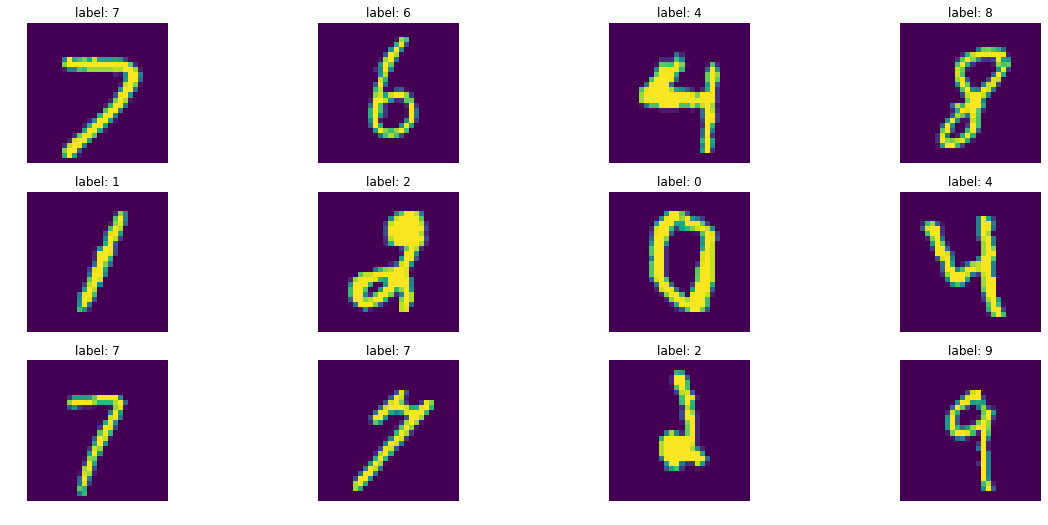

In [4]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    idx = random.randint(0, len(X)-1)
    image_row_vector = X[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### DCGAN

- Reference: https://github.com/pytorch/examples/blob/master/dcgan/main.py

Main idea of DCGAN lies in the terms of giving architecture guidelines to ensure stable training of GANs on CNNs. The main guidelines as summarized in the paper by the authors involve:

- replace any pooling layer with strided convolutions in discriminator and fractional-strided convolutions in generator
- batchnorm in both generator and discriminator
- no fully connected hidden layers in deep networks
- ReLU in generator for all layers but output layer which has Tanh activation
- LeakyReLU in discriminator for all layers

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchsummary import summary

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

DType: torch.float32
Cuda available: True
Device: cuda


### Bin count of Target Labels in the Dataset

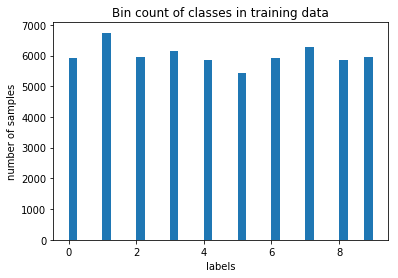

In [6]:
plt.hist(y, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in training data')
plt.show()

### Definition of Ally and Adversary Target Variables

Since there are not a explicit sensitive and preferred target variables in this particular dataset, I am sticking to creating custome target variables for the purpose of this experiment. 

In this case the adversary target variable would be to retrieve the exact label of the images while the ally would like to predict only whether it is an even or odd number.

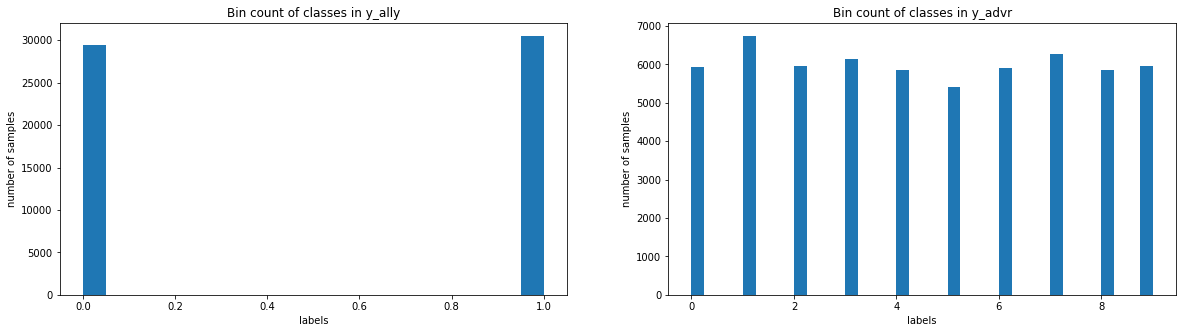

In [7]:
y_ally = y%2
y_advr = y

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(y_ally, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in y_ally')
plt.subplot(1, 2, 2)
plt.hist(y_advr, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in y_advr')
plt.show()

### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((54000, 784), (6000, 784), (54000,), (6000,), (54000,), (6000,))

### Validating the split

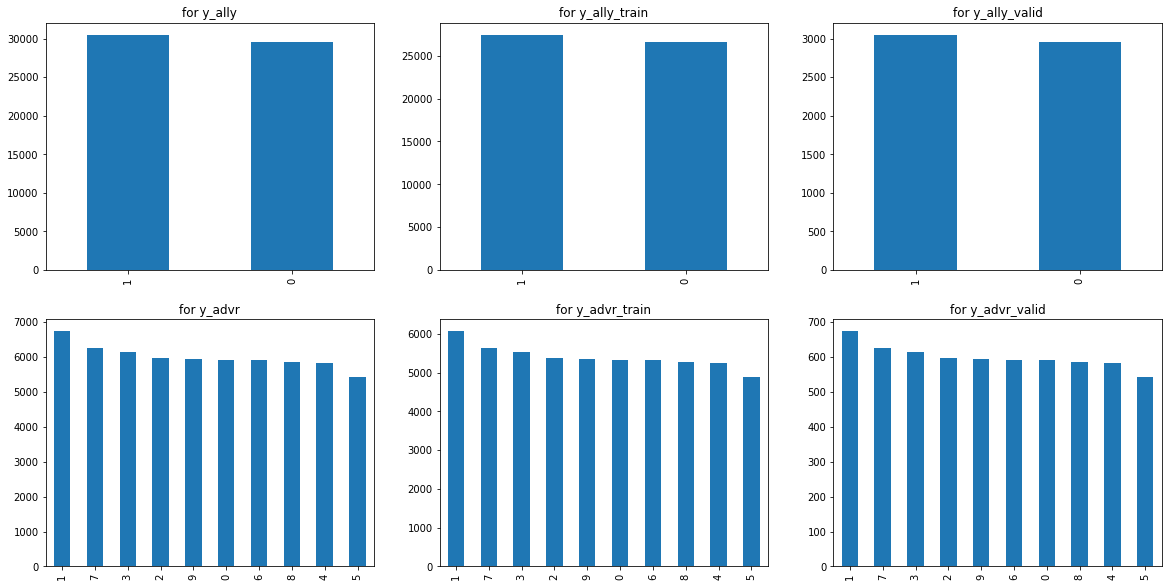

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaling for Normalization

Ideally this should be done at a batch level for larger dataset but here since the providers give the entire dataset in a single matrix it is possible to do this scaling for the entire dataset at one go.

There can be various options for scaling which includes Standard Scaling as well. I have used MinMax Scaling because of the ease of use and it is generally shown to maintain the distribution and work well with outliers.

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train.astype(np.float64))
X_train_normalized = scaler.transform(X_train.astype(np.float64))
X_valid_normalized = scaler.transform(X_valid.astype(np.float64))
X_train_normalized.shape, X_valid_normalized.shape

((54000, 784), (6000, 784))

### Validation Plot

To check if the images are affected at all by any of the normalization techniques which might be applied in the previous step, we plot and check visually for randomly picked elements that the images maintain their structure as they would have in the original scale image.

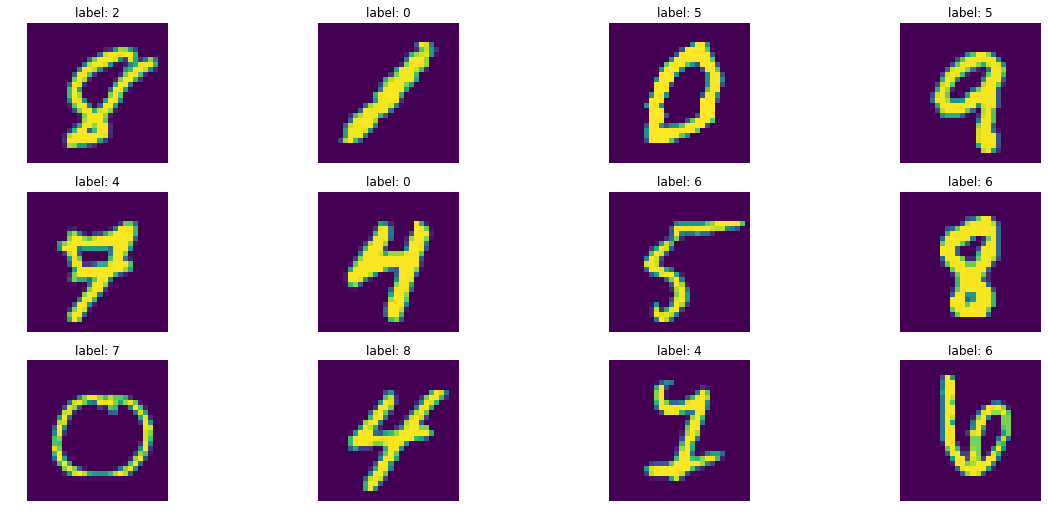

In [11]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    if _ % 2 == 0:
        idx = random.randint(0, len(X_train)-1)
        image_row_vector = X_train_normalized[idx]
    else:
        idx = random.randint(0, len(X_valid)-1)
        image_row_vector = X_valid_normalized[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### Apply PCA and select components using explained variances

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900822766830841 332


In [13]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((54000, 332), (6000, 332))

### Convert To Torch Tensors

In [14]:
def to_categorical(y, num_classes=None, dtype='float32'):

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

y_advr_train = to_categorical(y_advr_train)
y_advr_valid = to_categorical(y_advr_valid)
y_advr_train.shape, y_advr_valid.shape

((54000, 10), (6000, 10))

In [15]:
y_ally_train = y_ally_train.reshape(-1, 1)
y_ally_valid = y_ally_valid.reshape(-1, 1)
y_ally_train.shape, y_ally_valid.shape

((54000, 1), (6000, 1))

### Apply Autoencoders

In [16]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [17]:
auto_encoder = AutoEncoder(input_size=X_train_normalized.shape[1], encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

summary(auto_encoder, input_size=(1, X_train_normalized.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 332]         260,620
              ReLU-2               [-1, 1, 332]               0
            Linear-3               [-1, 1, 784]         261,072
           Sigmoid-4               [-1, 1, 784]               0
Total params: 521,692
Trainable params: 521,692
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.99
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


In [61]:
dataset_train = utils.TensorDataset(torch.Tensor(X_train_normalized))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(torch.Tensor(X_valid_normalized))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=True, num_workers=2)

In [19]:
print("epoch \t Aencoder_train \t Aencoder_valid")

auto_encoder.train()


ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(20):
    for i, data_train in enumerate(dataloader_train, 0):
        X_train_torch = data_train[0].to(device)
        ae_optimizer.zero_grad()

        X_train_torch_hat = auto_encoder(X_train_torch)
        ae_loss = criterion(X_train_torch_hat, X_train_torch)
        ae_loss.backward(retain_graph=True)
        ae_optimizer.step()

    nsamples = 0
    ae_valid_loss = 0
    for j, data_valid in enumerate(dataloader_valid, 0):
        X_valid_torch = data_valid[0].to(device)
        X_valid_torch_hat = auto_encoder(X_valid_torch)
        ae_valid_loss += criterion(X_valid_torch_hat, X_valid_torch)
        nsamples += 1

    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss/nsamples
    ))
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss/nsamples)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.02180916 	 0.02162161
1 	 0.01052757 	 0.01098332
2 	 0.00705543 	 0.00733928
3 	 0.00512428 	 0.00552429
4 	 0.00400890 	 0.00456358
5 	 0.00380162 	 0.00395557
6 	 0.00279926 	 0.00352024
7 	 0.00290139 	 0.00323811
8 	 0.00249870 	 0.00296437
9 	 0.00221437 	 0.00278770
10 	 0.00184587 	 0.00265155
11 	 0.00181234 	 0.00254346
12 	 0.00191927 	 0.00244586
13 	 0.00183191 	 0.00234926
14 	 0.00165552 	 0.00224383
15 	 0.00163471 	 0.00216112
16 	 0.00169486 	 0.00209306
17 	 0.00150055 	 0.00202836
18 	 0.00142798 	 0.00197653
19 	 0.00129128 	 0.00191872


- Convergence of autoencoded on this image dataset seems to be very accurate.
- Loss function used here is MLE instead of Crossentropy because it was showing better convergence.

In [ ]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

In [ ]:
auto_encoder.eval()

X_train_ae_torch = []
for data_train in dataloader_train:
    X_train_torch = data_train[0].to(device)
    X_train_ae_torch.append(auto_encoder.encoder(X_train_torch))
X_train_ae_torch = torch.cat(X_train_ae_torch)
                            
X_valid_ae_torch = []
for data_valid in dataloader_valid:
    X_valid_torch = data_valid[0].to(device)
    X_valid_ae_torch.append(auto_encoder.encoder(X_valid_torch))
X_valid_ae_torch = torch.cat(X_valid_ae_torch)
                            
X_train_ae_torch.shape, X_valid_ae_torch.shape

### Constants Explained

- nz: encoding dimension
- ngf: generator filters that are scaled by factors 2, 4, 8 etc.
- ndf: disciminator filter similar to ngf
- nc: number of channels
- ngpu: number of physical gpus on system
- batchSize: number of instances for SGD

In [23]:
nz = 50
ngf = 56
ndf = 56
nc = 1
ngpu = 1
batchSize = 512

### Weights and Bias Initialization

- It has been shown heuristically that weights intialized normally tend to perform better when compared to random initialization. So the first function tries to achieve this goal.

- In the definition of Generator and Discriminator, sometimes the number of strides, kernel_size and pooling is adjusted to meet the final size of the output desired. 

- It can be seen that there are no fully connected layers in both G and D
- Also batchnorm is applied on all layers 
- ReLU on each layer except output
- Tanh on output layer

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

- LeakyReLU on each layer
- BatchNorm on each layer
- Sigmoid in last layer to ensure probabilistic output 
- Sigmoid helps apply the BCE criterion at the end on the loss for optimizer
- BCE is binary cross-entropy loss function

In [25]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 2, 4, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 2, 4, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 2, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, X_train_reduced.shape[1], 2, 4, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).squeeze(2).squeeze(2)

In [26]:
class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.softmax = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.softmax(output)
        return output

In [27]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

summary(netG, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 56, 8, 8]             224
         LeakyReLU-2             [-1, 56, 8, 8]               0
            Conv2d-3            [-1, 112, 3, 3]          25,088
       BatchNorm2d-4            [-1, 112, 3, 3]             224
         LeakyReLU-5            [-1, 112, 3, 3]               0
            Conv2d-6            [-1, 224, 2, 2]         100,352
       BatchNorm2d-7            [-1, 224, 2, 2]             448
         LeakyReLU-8            [-1, 224, 2, 2]               0
            Conv2d-9            [-1, 332, 1, 1]         297,472
             Tanh-10            [-1, 332, 1, 1]               0
Total params: 423,808
Trainable params: 423,808
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 1.62
Estimated T

In [28]:
netF = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
netF.apply(weights_init)
netE = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
netE.apply(weights_init)

summary(netF, input_size=(1, X_train_reduced.shape[1]))
summary(netE, input_size=(1, X_train_reduced.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          42,624
              ReLU-2               [-1, 1, 128]               0
            Linear-3                 [-1, 1, 1]             129
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 42,753
Trainable params: 42,753
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          42,624
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1,

In [29]:
criterion = nn.BCEWithLogitsLoss()
crossentropy = nn.CrossEntropyLoss()

optimizerG = optim.Adam(netG.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizerF = optim.Adam(netF.parameters(), lr=0.0000001, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=0.0000001, betas=(0.5, 0.999))

### Create dataset and load

- Fixing the batchsize after creating dataset

In [30]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)), 
    torch.Tensor(y_ally_train.reshape(-1, 1)), 
    torch.Tensor(y_advr_train.reshape(-1, 10))
)

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize,
                                         shuffle=True, num_workers=2)


X_valid_torch = torch.Tensor(X_valid_normalized.reshape(-1, 1, 28, 28)).to(device)
X_valid_reduced_torch = torch.Tensor(X_valid_reduced).to(device)

y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1)).to(device)
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 10)).to(device)

X_valid_torch.shape, X_valid_reduced_torch.shape, y_ally_valid_torch.shape, y_advr_valid_torch.shape

(torch.Size([6000, 1, 28, 28]),
 torch.Size([6000, 332]),
 torch.Size([6000, 1]),
 torch.Size([6000, 10]))

### Model Parameters

- need to tweak the values of learning rate for generator and discriminator
- if the value is not optimal, discriminator might converge too soon and then generator will collapse 
- so the parameter tweaking is a must to find the right balance

In [31]:
alpha = 0.5
netG.train()
netF.train()
netE.train()

Adversary(
  (fc1): Linear(in_features=332, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Sigmoid()
)

In [32]:
niter = 20
outf = 'result'

gan_epoch = []
gan_g_loss_train = []
gan_g_loss_valid = []
gan_f_loss_train = []
gan_f_loss_valid = []
gan_e_loss_train = []
gan_e_loss_valid = []

for epoch in range(niter):
    gan_epoch.append(epoch)
    for i, data in enumerate(dataloader, 0):
        X_train_torch = data[0].to(device)
        y_ally_train_torch = data[1].to(device)
        y_advr_train_torch = data[2].to(device)

        for i in range(10):
            optimizerF.zero_grad()
            X_train_encoded = netG(X_train_torch)
            y_ally_train_hat_torch = netF(X_train_encoded)
            lossF = criterion(y_ally_train_hat_torch, y_ally_train_torch)
            lossF.backward()
            optimizerF.step()
            
            optimizerE.zero_grad()
            X_train_encoded = netG(X_train_torch)
            y_advr_train_hat_torch = netE(X_train_encoded)
            lossE = criterion(y_advr_train_hat_torch, y_advr_train_torch)
            lossE.backward()
            optimizerE.step()
            
            
        optimizerG.zero_grad()
        # Forward pass
        X_train_encoded = netG(X_train_torch)
        y_ally_train_hat_torch = netF(X_train_encoded)
        y_advr_train_hat_torch = netE(X_train_encoded)
        # Compute Loss
        lossF = criterion(y_ally_train_hat_torch, y_ally_train_torch)
        lossE = criterion(y_advr_train_hat_torch, y_advr_train_torch)
        lossG = alpha * lossF - (1-alpha) * lossE
        # Backward pass
        lossG.backward()
        optimizerG.step()

    X_valid_encoded = netG(X_valid_torch)
    y_ally_valid_hat_torch = netF(X_valid_encoded)
    y_advr_valid_hat_torch = netE(X_valid_encoded)

    valid_lossF = criterion(y_ally_valid_hat_torch, y_ally_valid_torch)
    valid_lossE = criterion(y_advr_valid_hat_torch, y_advr_valid_torch)
    valid_lossG = alpha * valid_lossF -(1-alpha) * valid_lossE

    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossG.item(),
        valid_lossG.item(),
        lossF.item(), 
        valid_lossF.item(),
        lossE.item(),
        valid_lossE.item(),
    ))
    
    gan_g_loss_train.append(lossG.item())
    gan_g_loss_valid.append(valid_lossG.item())
    gan_f_loss_train.append(lossF.item())
    gan_f_loss_valid.append(valid_lossF.item())
    gan_e_loss_train.append(lossE.item())
    gan_e_loss_valid.append(valid_lossE.item())

0 	 -0.12037086 	 -0.11051276 	 0.69736195 	 0.71705127 	 0.93810368 	 0.93807679
1 	 -0.11548957 	 -0.11652076 	 0.71464223 	 0.71273398 	 0.94562137 	 0.94577551
2 	 -0.12152648 	 -0.12163115 	 0.70962572 	 0.70955837 	 0.95267868 	 0.95282066
3 	 -0.11807269 	 -0.12593207 	 0.72270024 	 0.70712638 	 0.95884562 	 0.95899051
4 	 -0.12232101 	 -0.12962985 	 0.71995306 	 0.70532405 	 0.96459508 	 0.96458375
5 	 -0.12598521 	 -0.13285711 	 0.71757615 	 0.70380026 	 0.96954656 	 0.96951449
6 	 -0.12660190 	 -0.13562021 	 0.72081965 	 0.70257342 	 0.97402346 	 0.97381383
7 	 -0.14134410 	 -0.13784155 	 0.69419497 	 0.70154792 	 0.97688317 	 0.97723103
8 	 -0.13722417 	 -0.13957772 	 0.70543814 	 0.70068049 	 0.97988647 	 0.97983593
9 	 -0.14261523 	 -0.14102405 	 0.69660765 	 0.69994056 	 0.98183811 	 0.98198867
10 	 -0.14750898 	 -0.14213300 	 0.68855160 	 0.69928443 	 0.98356956 	 0.98355043
11 	 -0.14282838 	 -0.14291722 	 0.69874096 	 0.69869894 	 0.98439771 	 0.98453337
12 	 -0.139297

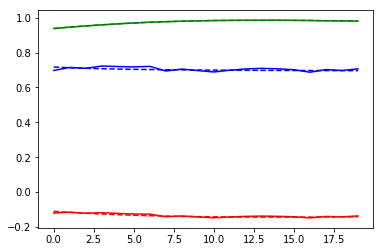

In [35]:
plt.plot(gan_epoch, gan_g_loss_train, 'r')
plt.plot(gan_epoch, gan_g_loss_valid, 'r--')
plt.plot(gan_epoch, gan_f_loss_train, 'b')
plt.plot(gan_epoch, gan_f_loss_valid, 'b--')
plt.plot(gan_epoch, gan_e_loss_train, 'g')
plt.plot(gan_epoch, gan_e_loss_valid, 'g--')
plt.show()

- Legend: 
    - red: encoder
    - blue: ally
    - green: adversary
- The variations are not very descriptive in the current scale of y axis. Trying to tweak model parameters to see if more variation and better convergence curve can be seen on the graph

### Save Model

In [ ]:
torch.save(netG, 'models/netG.pkl')
torch.save(netF, 'models/netF.pkl')
torch.save(netE, 'models/netE.pkl')

### Ally and Adversary Training on PCA Data

In [ ]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_reduced), 
    torch.Tensor(y_ally_train.reshape(-1, 1)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_reduced), 
    torch.Tensor(y_ally_valid.reshape(-1, 1)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netF_pca = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerF = optim.Adam(netF_pca.parameters(), lr=0.001)
criterion = nn.BCELoss()


n_epoch = []
train = []
valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_ally_torch = data_train[1].to(device)
        
        optimizerF.zero_grad()
        
        y_train_ally_torch_hat = netF_pca(X_train_torch)

        lossF = criterion(y_train_ally_torch_hat, y_train_ally_torch)
        lossF.backward()
        
        optimizerF.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_ally_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netF_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_ally_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossF.item(),
        valid_loss,
    ))
    n_epoch.append(epoch)
    train.append(lossF.item())
    valid.append(valid_loss)
        

In [ ]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_reduced), 
    torch.Tensor(y_advr_train.reshape(-1, 10)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_reduced), 
    torch.Tensor(y_advr_valid.reshape(-1, 10)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netE_pca = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerE = optim.Adam(netE_pca.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


train_a = []
valid_a = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_advr_torch = data_train[1].to(device)
        
        optimizerE.zero_grad()
        
        y_train_advr_torch_hat = netE_pca(X_train_torch)

        lossE = criterion(y_train_advr_torch_hat, y_train_advr_torch)
        lossE.backward()
        
        optimizerE.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_advr_torch = data_valid[1].to(device)
        y_valid_advr_torch_hat = netE_pca(X_valid_torch)
        valid_l = criterion(y_valid_advr_torch_hat, y_valid_advr_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossE.item(),
        valid_loss,
    ))
    train_a.append(lossE.item())
    valid_a.append(valid_loss)
        

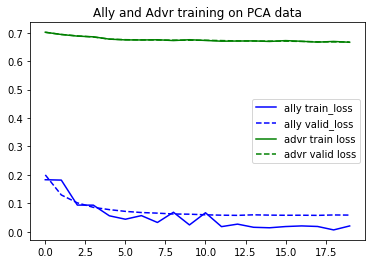

In [103]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend([
    'ally train_loss', 
    'ally valid_loss', 
    'advr train loss', 
    'advr valid loss'
])
plt.title("Ally and Advr training on PCA data")
plt.show()

- The convergence on both ally and adversary is standard
- No signs of overfitting

### Ally and Adversary Training on AutoEncoder Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

dataset_train = utils.TensorDataset(
    X_train_ae_torch.detach().cpu(), 
    torch.Tensor(y_ally_train.reshape(-1, 1)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    X_valid_ae_torch.detach().cpu(), 
    torch.Tensor(y_ally_valid.reshape(-1, 1)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netF_pca = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerF = optim.Adam(netF_pca.parameters(), lr=0.01)
criterion = nn.BCELoss()


ae_ally_train=[]
ae_ally_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_ally_torch = data_train[1].to(device)
        
        optimizerF.zero_grad()
        
        y_train_ally_torch_hat = netF_pca(X_train_torch)

        lossF = criterion(y_train_ally_torch_hat, y_train_ally_torch)
        lossF.backward()
        
        optimizerF.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_ally_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netF_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_ally_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossF.item(),
        valid_loss,
    ))
    ae_ally_train.append(lossF.item())
    ae_ally_valid.append(valid_loss)

In [107]:
dataset_train = utils.TensorDataset(
    X_train_ae_torch.detach().cpu(), 
    torch.Tensor(y_advr_train.reshape(-1, 10)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    X_valid_ae_torch.detach().cpu(), 
    torch.Tensor(y_advr_valid.reshape(-1, 10)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netE_pca = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerE = optim.Adam(netE_pca.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()


ae_advr_train = []
ae_advr_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_advr_torch = data_train[1].to(device)
        
        optimizerE.zero_grad()
        
        y_train_advr_torch_hat = netE_pca(X_train_torch)

        lossE = criterion(y_train_advr_torch_hat, y_train_advr_torch)
        lossE.backward()
        
        optimizerE.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_advr_torch = data_valid[1].to(device)
        y_valid_advr_torch_hat = netE_pca(X_valid_torch)
        valid_l = criterion(y_valid_advr_torch_hat, y_valid_advr_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossE.item(),
        valid_loss,
    ))
    ae_advr_train.append(lossE.item())
    ae_advr_valid.append(valid_loss)
        

0 	 0.69667196 	 0.69698607
1 	 0.69370288 	 0.69377205
2 	 0.69338351 	 0.69340357
3 	 0.69326687 	 0.69329013
4 	 0.69322830 	 0.69323924
5 	 0.69318748 	 0.69321213
6 	 0.69317800 	 0.69319492
7 	 0.69317257 	 0.69318396
8 	 0.69318557 	 0.69317658
9 	 0.69315749 	 0.69317125
10 	 0.69316363 	 0.69316734
11 	 0.69315666 	 0.69316408
12 	 0.69316739 	 0.69316157
13 	 0.69316083 	 0.69315951
14 	 0.69315749 	 0.69315795
15 	 0.69315636 	 0.69315664
16 	 0.69315296 	 0.69315554
17 	 0.69315243 	 0.69315462
18 	 0.69315249 	 0.69315387
19 	 0.69315505 	 0.69315315


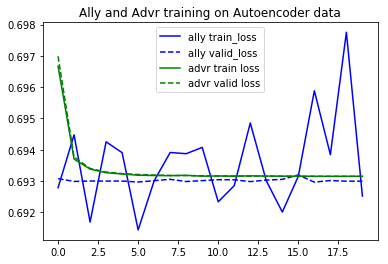

In [108]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

- Studying the graph we can see that the adversary is converging appropriately
- Ally network need model parameter tweaking to get rid of the divergence.

### Ally and Adversary training on Encoded Data

In [115]:
X_train_normalized.shape

(54000, 784)

In [ ]:
dataset_train = utils.TensorDataset(torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(torch.Tensor(X_valid_normalized.reshape(-1, 1, 28, 28)))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=True, num_workers=2)

X_train_encoded = []
for i, data in enumerate(dataset_train):
    X_train_iter = data[0].to(device)
    print(X_train_iter.shape)
    X_train_encoded.append(netG(X_train_iter))
X_train_encoded = torch.cat(X_train_encoded)
X_train_encoded.shape

In [ ]:
X_train_encoded = netG(X_train_torch)
X_valid_encoded = netG(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape